In [145]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [146]:
config = {
    "DATALAKE_DIR": os.path.abspath('../data/yfinance_fx_historical')
}

# data lake client object: for data selection, loading and transformation
class DatalakeClient:
    def __init__(self, config):
        self.config = config
    
    def get_table(self, ticker) -> pd.DataFrame:
        file_path = os.path.join(self.config['DATALAKE_DIR'], 'raw_data', f'{ticker}_historical_data.csv')
        df = pd.read_csv(file_path, header=0)
        return df
    

In [147]:
# statistic tests

# stationarity
def perform_adf_test(series):
    """
    Perform the Augmented Dickey-Fuller test on a time series.

    :param series: Time series data.
    :return: ADF test result with test statistic, p-value, and critical values.
    """
    adf_test = adfuller(series, autolag='AIC')  # Using AIC to choose the lag
    result = pd.Series(adf_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

    for key, value in adf_test[4].items():
        result[f'Critical Value ({key})'] = value

    return result

# Example usage:
# series = df['YourTimeSeriesColumn']
# print(perform_adf_test(series))


In [148]:
# turn df to sequences
def rolling_window_sequences(df, window_size):
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame.")

    num_rows, num_columns = df.shape
    if num_rows < window_size:
        raise ValueError(f'DataFrame must have more rows than {window_size=}: {num_rows=}')

    series = df.values

    # Calculate shape and strides for the rolling window
    shape = (num_rows - window_size + 1, window_size, num_columns)
    strides = (series.strides[0], series.strides[0], series.strides[1])

    return np.lib.stride_tricks.as_strided(series, shape=shape, strides=strides)

# Example usage:
# series = np.array([your_data_series])
# window_size = 5  # for example, a window size of 5
# sequences = rolling_window_sequences(series, window_size)
# print(sequences)


In [149]:
# sampling
def sample_random_rows(array, num_samples):
    """
    Randomly sample rows from a numpy array.

    :param array: Input numpy array.
    :param num_samples: Number of rows to sample.
    :return: A numpy array containing randomly sampled rows.
    """
    if num_samples > len(array):
        raise ValueError("Number of samples requested exceeds the number of rows in the array.")

    # Randomly choose row indices
    indices = np.random.choice(len(array), size=num_samples, replace=False)

    # Select the rows
    sampled_rows = array[indices]

    return sampled_rows

# Example usage:
# array = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])
# num_samples = 2
# sampled_rows = sample_random_rows(array, num_samples)
# print(sampled_rows)

In [150]:
# labeling
# triple barries methods
def label_ohlc_sequences(ohlc_sequences, r_stop, r_take):
    """
    Labels each sequence in a numpy array of OHLC sequences.

    Args:
        ohlc_sequences (np.array): Numpy array where each row is an OHLC sequence.
        r_stop (float): Percentage loss for stop loss.
        r_take (float): Percentage gain for take profit.
        T (int): Horizon of trading (number of steps in each sequence).

    Returns:
        np.array: Array of labels (1 for take profit, -1 for stop loss, 0 for end of the horizon).
    """
    labels = []

    for sequence in ohlc_sequences:
        entry_price = sequence[0, 0]  # Open price of the first day in the sequence. Assume you get the signal last night and buy in the morning of the market
        take_profit_price = entry_price * (1 + r_take)
        stop_loss_price = entry_price * (1 - r_stop)

        label = 0  # Default label (hold till end of horizon)
        final_price = sequence[-1, 3]  # Close price of the last day in the sequence

        for day in sequence:
            day_high = day[1]  # High price of the day
            day_low = day[2]  # Low price of the day

            if day_high >= take_profit_price:
                label = 1  # Take profit
                final_price = take_profit_price
                break
            elif day_low <= stop_loss_price:
                label = -1  # Stop loss
                final_price = stop_loss_price
                break

        actual_return = final_price - entry_price
        labels.append((label, actual_return))

    return np.array(labels)

# Example usage:
# ohlc_sequences = np.array([[your_ohlc_data]])  # Replace with your OHLC data
# r_stop = 0.02  # Example stop loss percentage
# r_take = 0.03  # Example take profit percentage
# T = 5  # Trading horizon
# labels = label_ohlc_sequences(ohlc_sequences, r_stop, r_take, T)
# print(labels)


In [161]:
# feature engineering

def plot_weights(start, end, n_plots, size):
    w = pd.DataFrame()
    for d in np.linspace(start, end, n_plots):
        w_ = get_weights(d, size=size)
        w_ = pd.DataFrame(w_, index=range(w_.shape[0])[::-1], columns=[d])
        w = w.join(w_, how='outer')
    ax = w.plot()
    ax.legend(loc='upper left')
    plt.show()

def get_weights(d, size):
    # Weights for fractional differentiation
    # the series of weights is a binomail series?
    w = [1.]
    for k in range(1, size):
        w.append(-w[-1] * ((d - k + 1)) / k)
    w = np.array(w[::-1]).reshape(-1, 1)
    return w


def fractional_differentiation(array, order, threshold=0.01):
    """
    Applies fractional differentiation to a time series.
    This refers to the Fixed-Width window fracdiff

    :param array: A time series data.
    :param order: Fractional order (d).
    :param threshold: Cutoff threshold for weights.
    :return: Fractionally differentiated series.
    """
    # Length of the time series
    array_length = len(array)

    # Getting the weights
    weights = get_weights(order, array_length)

    # Adjust weights for threshold
    weights = np.array(weights[np.abs(weights) > threshold])
    diff_series_length = array_length - len(weights) + 1

    # Applying the weights to the series
    diff_series = []
    for i in range(diff_series_length):
        window = array[i:i + len(weights)]
        # Handle scalar result of np.dot
        result = np.dot(weights.T, window)
        if np.isscalar(result):
            diff_series.append(result)
        else:
            diff_series.append(result[0])

#     diff_series = pd.Series(diff_series, index=series.index[-diff_series_length:])
    return np.array(diff_series)
    


def fractional_differentiation_multi_channel(array, order, threshold=0.01):
    """
    TODO: better do it with broadcasting
    Assume array is a (N, seq, channels) array
    """
    array_result = []
    for i in range(array.shape[0]):
        array_channels = []
        for channel in range(array.shape[2]):
            array_channel = fractional_differentiation(array[i, :, channel], order, threshold)
            array_channels.append(array_channel)
        array_result.append(array_channels)
    return np.array(array_result)
        

# Example usage with a DataFrame
# df = pd.read_csv('path_to_your_GOOGLE_ohlcv_data.csv')
# order = 0.5  # example fractional order
# df_fractionally_diff = df.apply(lambda x: fractional_differentiation(x, order) if x.name in ['Open', 'High', 'Low', 'Close', 'Volume'] else x)

def plot_min_ffd(array, n_plots, threshold):
    df_out = pd.DataFrame(columns=['adfStat', 'pVal','lags','nObs','95% conf','corr'])
    for d in np.linspace(0, 1, n_plots):
        fd_series = fractional_differentiation(array, d, threshold)
#         fd_series = fd_series.dropna()
        n_nan = len(array) - len(fd_series)
        corr = np.corrcoef(array[n_nan:], fd_series)[0, 1]
        
        test_result = perform_adf_test(fd_series)
        df_out.loc[d] = [
            test_result['Test Statistic'],
            test_result['p-value'],
            test_result['#Lags Used'],
            test_result['Number of Observations Used'],
            test_result['Critical Value (5%)'],
            corr,
        ]
    df_out[['adfStat','corr']].plot(secondary_y='adfStat')
    plt.axhline(df_out['95% conf'].mean(),linewidth=1,color='r',linestyle='dotted')
    return df_out

        
        

In [152]:
# train test splitting
# train, test

def train_test_split_with_gap(array, test_size, gap_size):
    """
    Splits a numpy array into training and testing sets with a gap between them.

    :param array: Input numpy array.
    :param test_size: Fraction of the dataset to include in the test split.
    :param gap_size: Size of the gap between training and testing sets.
    :return: Training set, Testing set
    """
    if not 0 < test_size < 1:
        raise ValueError("Test size should be a fraction between 0 and 1.")

    if not isinstance(gap_size, int) or gap_size < 0:
        raise ValueError("Gap size should be a non-negative integer.")

    total_size = len(array)
    test_set_size = int(np.floor(total_size * test_size))
    train_set_size = total_size - test_set_size - gap_size

    if train_set_size <= 0 or train_set_size + gap_size + test_set_size > total_size:
        raise ValueError("Invalid combination of test size and gap size for the given array.")

    train_set = array[:train_set_size]
    test_set = array[train_set_size + gap_size:]

    return train_set, test_set

# Example usage:
# array = np.array([your_data])
# test_size = 0.2  # e.g., 20% of the data for testing
# gap_size = 10    # e.g., 10 data points gap
# train_set, test_set = train_test_split_with_gap(array, test_size, gap_size)


In [153]:
# modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, f1_score


def train_random_forest(x_train, y_train, x_test=None, y_test=None, random_state=None):
    """
    Train a Random Forest classifier on the given features and labels.

    Args:
        features (np.array): The feature set (numpy array).
        labels (np.array): The labels (numpy array).
        test_size (float): Fraction of the dataset to include in the test split.
        random_state (int, optional): Controls the randomness of the bootstrapping of the samples. Defaults to None.

    Returns:
        RandomForestClassifier: Trained Random Forest model.
        dict: A dictionary containing the model's performance metrics.
    """
    # Split the data into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=random_state)

    # Initialize and train the Random Forest classifier
    clf = RandomForestClassifier(random_state=random_state)
    clf.fit(x_train, y_train)
    
    if x_test is not None and y_test is not None:
        # Predict on the test set
        y_pred = clf.predict(x_test)
        y_pred_prob = clf.predict_proba(x_test)[:, 1]  # Probabilities for ROC AUC
        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')  # F1 Score
        # Compute ROC AUC Score
        if len(np.unique(y_test)) == 2:  # Binary classification
            roc_auc = roc_auc_score(y_test, y_pred_prob)  # Use probabilities for the positive class
        else:  # Multi-class classification
            roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')  # One-vs-Rest approach
        report = classification_report(y_test, y_pred)

        # Print the evaluation metrics
        print("Classification Report:")
        print(report)
        print("Accuracy:", accuracy)
        print("F1 Score:", f1)
        print("ROC AUC Score:", roc_auc)
        return clf, {"accuracy": accuracy, "f1_score": f1, "roc_auc": roc_auc, "classification_report": report}
    else:
        return clf

# Example usage:
# features = np.array([your_feature_set])
# labels = np.array([your_labels])
# trained_model, performance = train_random_forest(features, labels)

In [154]:
# get datalake client
dl_client = DatalakeClient(config)

In [155]:
df = dl_client.get_table(ticker='GOOGL')

# Generating summary statistics and information about the dataset
summary_statistics = df.describe()
df_info = df.info()

print(df_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2514 entries, 0 to 2513
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2514 non-null   object 
 1   Open       2514 non-null   float64
 2   High       2514 non-null   float64
 3   Low        2514 non-null   float64
 4   Close      2514 non-null   float64
 5   Adj Close  2514 non-null   float64
 6   Volume     2514 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 137.6+ KB
None


## Regression model

Predict the variable p_take, p_stop under the triple barrier labling method.

### Feature:
1. Fractional Differentiated Feature
    - last 14 days log prices
    - apply ffd
    - use triple barrier for labeling
    - use random foreset as classifier
    
### Sampling trading data:
2. Sampling 

In [156]:
# hyperparams
FEATURE_WINDOW_SIZE = 28
LABEL_WINDOW_SIZE = 14
WINDOW_SIZE = FEATURE_WINDOW_SIZE + LABEL_WINDOW_SIZE

R_STOP = 0.02
R_TAKE = 0.04

# Transformation

In [157]:
seqs = rolling_window_sequences(df[['Open', 'High', 'Low', 'Close']], window_size=WINDOW_SIZE)
seqs.shape

(2473, 42, 4)

# Train-test splitting

In [158]:
train_seqs, test_seqs = train_test_split_with_gap(seqs, test_size=0.1, gap_size=28)
train_seqs.shape, test_seqs.shape

((2198, 42, 4), (247, 42, 4))

# Feature Engineering

,adfStat,pVal,lags,nObs,95% conf,corr
0.0,-2.361449,0.152914,1.0,40.0,-2.937069,1.000000
0.1,-2.865678,0.049487,1.0,33.0,-2.954127,0.987669
0.2,-3.528346,0.007288,1.0,30.0,-2.964071,0.947482
0.3,-3.786335,0.003050,1.0,29.0,-2.967882,0.885429
0.4,-4.098327,0.000975,1.0,30.0,-2.964071,0.808551
0.5,-4.277953,0.000485,1.0,31.0,-2.960525,0.715511
0.6,-4.387325,0.000313,2.0,31.0,-2.960525,0.625600
0.7,-4.684678,0.000090,2.0,33.0,-2.954127,0.463747
0.8,-4.981620,0.000024,2.0,34.0,-2.951230,0.351278
0.9,-5.276130,0.000006,2.0,36.0,-2.945951,0.257632


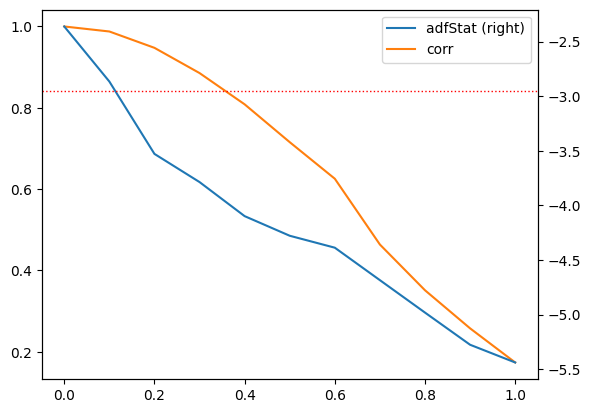

In [162]:
plot_min_ffd(train_seqs[0, :, 0], 11, 0.01)

In [138]:
# fracdiff
x_train = fractional_differentiation_multi_channel(train_seqs[:, :FEATURE_WINDOW_SIZE, :], order=0.63, threshold=0.01)
x_test = fractional_differentiation_multi_channel(test_seqs[:, :FEATURE_WINDOW_SIZE, :], order=0.63, threshold=0.01)
x_train.shape, x_test.shape

((2198, 4, 21), (247, 4, 21))

In [139]:
# flatten the last 2 dimension
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
x_train.shape, x_test.shape

((2198, 84), (247, 84))

# Labelling

In [140]:
# label and return
y_train = label_ohlc_sequences(train_seqs[:, :FEATURE_WINDOW_SIZE, :], r_take=R_TAKE, r_stop=R_STOP)
y_test = label_ohlc_sequences(test_seqs[:, :FEATURE_WINDOW_SIZE, :], r_take=R_TAKE, r_stop=R_STOP)
y_train.shape, y_test.shape

((2198, 2), (247, 2))

# Sampling

In [141]:
# adf tests
# n_rejects = 0

# for i in range(new_sequences.shape[0]):
#     result = perform_adf_test(new_sequences[0])
#     if result['p-value'] < 0.05:
#         n_rejects += 1
# print('percentage of reject: ', n_rejects / new_sequences.shape[0])

In [142]:
# correlations
# corrs = []

# for i in range(new_sequences.shape[0]):
#     n_drop = sequences.shape[1] - new_sequences.shape[1]
#     corr = np.corrcoef(sequences[i, n_drop:], new_sequences[i])[0, 1]
#     corrs.append(corr)
    
# print('median corr: ', np.median(corrs))
# print('mean corr: ', np.mean(corrs))
# print('min corr: ', np.min(corrs))
# print('max corr: ', np.max(corrs))

# Modelling

1. Random forest

In [143]:
# random forest
clf = train_random_forest(
    x_train=x_train,
    y_train=y_train[:, 0],
    x_test=x_test,
    y_test=y_test[:, 0],
    random_state=0
)


Classification Report:
              precision    recall  f1-score   support

        -1.0       0.61      0.87      0.72       150
         1.0       0.41      0.14      0.21        97

    accuracy                           0.58       247
   macro avg       0.51      0.51      0.46       247
weighted avg       0.53      0.58      0.52       247

Accuracy: 0.582995951417004
F1 Score: 0.518910287272901
ROC AUC Score: 0.5


In [144]:
n_stop = sum(y_test[:, 0] == -1) / y_test.shape[0]
n_take = sum(y_test[:, 0] == 1) / y_test.shape[0]
print(n_stop)
print(n_take)

0.6072874493927125
0.39271255060728744
